In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.linear_model import Ridge, LinearRegression, Lasso
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, RobustScaler
from sklearn.impute import SimpleImputer
from scipy import sparse
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline, Pipeline

### historical S&P data, 1978-2022

In [64]:
df_sp = pd.read_csv('HistoricalPrices1978.csv')
df_sp

,Date,Open,High,Low,Close
0,05/11/22,3990.08,4049.09,3928.82,3935.18
1,05/10/22,4035.18,4068.82,3958.17,4001.05
2,05/09/22,4081.27,4081.27,3975.48,3991.24
3,05/06/22,4128.17,4157.69,4067.91,4123.34
4,05/05/22,4270.43,4270.43,4106.01,4146.87
...,...,...,...,...,...
11181,01/09/78,90.64,91.52,90.01,90.64
11182,01/06/78,91.62,92.66,91.05,91.62
11183,01/05/78,92.74,94.53,92.51,92.74
11184,01/04/78,93.52,94.10,93.16,93.52


In [65]:
df_sp[["day", "month", "year"]] = df_sp["Date"].str.split("/", expand = True)
df_sp.head()

,Date,Open,High,Low,Close,day,month,year
0,05/11/22,3990.08,4049.09,3928.82,3935.18,05,11,22
1,05/10/22,4035.18,4068.82,3958.17,4001.05,05,10,22
2,05/09/22,4081.27,4081.27,3975.48,3991.24,05,09,22
3,05/06/22,4128.17,4157.69,4067.91,4123.34,05,06,22
4,05/05/22,4270.43,4270.43,4106.01,4146.87,05,05,22


In [66]:
df_sp = df_sp.rename(columns={'Date':'date', ' Open':'open', ' High':'high', ' Low':'low',
                             ' Close':'close'})
df_sp.head()

,date,open,high,low,close,day,month,year
0,05/11/22,3990.08,4049.09,3928.82,3935.18,05,11,22
1,05/10/22,4035.18,4068.82,3958.17,4001.05,05,10,22
2,05/09/22,4081.27,4081.27,3975.48,3991.24,05,09,22
3,05/06/22,4128.17,4157.69,4067.91,4123.34,05,06,22
4,05/05/22,4270.43,4270.43,4106.01,4146.87,05,05,22


In [67]:
df_sp['avg_open_yr'] = df_sp.groupby(df_sp['year'])['open'].transform('mean')
df_sp['avg_high_yr'] = df_sp.groupby(df_sp['year'])['high'].transform('mean')
df_sp['avg_low_yr'] = df_sp.groupby(df_sp['year'])['low'].transform('mean')
df_sp.head()

,date,open,high,low,close,day,month,year,avg_open_yr,avg_high_yr,avg_low_yr
0,05/11/22,3990.08,4049.09,3928.82,3935.18,05,11,22,4423.340444,4458.361111,4374.597222
1,05/10/22,4035.18,4068.82,3958.17,4001.05,05,10,22,4423.340444,4458.361111,4374.597222
2,05/09/22,4081.27,4081.27,3975.48,3991.24,05,09,22,4423.340444,4458.361111,4374.597222
3,05/06/22,4128.17,4157.69,4067.91,4123.34,05,06,22,4423.340444,4458.361111,4374.597222
4,05/05/22,4270.43,4270.43,4106.01,4146.87,05,05,22,4423.340444,4458.361111,4374.597222


In [68]:
df_sp_yr = df_sp[['year', 'avg_open_yr', 'avg_high_yr', 'avg_low_yr']]
df_sp_yr.head()

,year,avg_open_yr,avg_high_yr,avg_low_yr
0,22,4423.340444,4458.361111,4374.597222
1,22,4423.340444,4458.361111,4374.597222
2,22,4423.340444,4458.361111,4374.597222
3,22,4423.340444,4458.361111,4374.597222
4,22,4423.340444,4458.361111,4374.597222


In [138]:
df_sp_final = df_sp_yr.drop_duplicates()
df_sp_final

,year,avg_open_yr,avg_high_yr,avg_low_yr
0,22,4423.340444,4458.361111,4374.597222
90,21,4271.170714,4291.877579,4251.042698
342,20,3217.750277,3242.183953,3190.484466
595,19,2911.627619,2923.622341,2899.439921
847,18,2747.784900,2762.655418,2730.275259
1098,17,2448.275896,2454.344821,2441.850677
1349,16,2094.091548,2103.306865,2083.753135
1601,15,2061.268016,2071.863095,2049.309524
1853,14,1930.754484,1938.835595,1922.292976
2105,13,1642.295516,1649.615714,1635.737024


In [180]:
df_sp_final['year'] = df_sp_final['year'].astype(int)

/var/folders/_7/h5pf_y9106z75mck2bx53gqw0000gn/T/ipykernel_8980/2375293518.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sp_final['year'] = df_sp_final['year'].astype(int)


In [181]:
df_sp_final.dtypes

year             int64
avg_open_yr    float64
avg_high_yr    float64
avg_low_yr     float64
dtype: object

In [182]:
years = df_sp_final['year'].values.tolist()

In [192]:
converted_yrs = []

for i in years:
    if i <= 23:
        i+=2000
        converted_yrs.append(i)
    else:
        i+=1900
        converted_yrs.append(i)

In [196]:
df_sp_final['converted_years'] = converted_yrs
df_sp_final = df_sp_final[['converted_years', 'avg_open_yr', 'avg_high_yr', 'avg_low_yr']]
df_sp_final.head()

/var/folders/_7/h5pf_y9106z75mck2bx53gqw0000gn/T/ipykernel_8980/1249340593.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sp_final['converted_years'] = converted_yrs


,converted_years,avg_open_yr,avg_high_yr,avg_low_yr
0,2022,4423.340444,4458.361111,4374.597222
90,2021,4271.170714,4291.877579,4251.042698
342,2020,3217.750277,3242.183953,3190.484466
595,2019,2911.627619,2923.622341,2899.439921
847,2018,2747.784900,2762.655418,2730.275259


### S&P since 1993

In [208]:
df_spy = pd.read_csv('SPY1993.csv')
df_spy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,25.547974,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.729685,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.784193,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.056751,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.165783,531500


In [209]:
df_spy = df_spy.sort_values(by='Date')
df_spy.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1993-01-29,43.96875,43.96875,43.75000,43.93750,25.547974,1003200
1,1993-02-01,43.96875,44.25000,43.96875,44.25000,25.729685,480500
2,1993-02-02,44.21875,44.37500,44.12500,44.34375,25.784193,201300
3,1993-02-03,44.40625,44.84375,44.37500,44.81250,26.056751,529400
4,1993-02-04,44.96875,45.09375,44.46875,45.00000,26.165783,531500


In [210]:
## pulls last date in every year

df_spy_yrend = df_spy.groupby(pd.DatetimeIndex(df_spy.Date).to_period('Y'), as_index=False).nth(-1)
df_spy_yrend.head()

,Date,Open,High,Low,Close,Adj Close,Volume
233,1993-12-31,46.937500,47.00000,46.56250,46.593750,27.772987,312900
485,1994-12-30,46.203125,46.25000,45.56250,45.562500,27.883350,2209500
737,1995-12-29,61.468750,61.53125,61.25000,61.484375,38.492661,339200
991,1996-12-31,75.281250,75.37500,73.84375,73.843750,47.152527,1378100
1244,1997-12-31,96.875000,97.62500,96.68750,97.062500,62.936913,4359500


In [212]:
df_spy_yrend[["year", "month", "day"]] = df_spy_yrend["Date"].str.split("-", expand = True)
df_spy_yrend['yyyy-mm'] = df_spy_yrend['year'] + '-' + df_spy_yrend['month']

df_agg = df_spy_yrend.groupby('year', as_index=False).agg({'High':'max', 'Low':'min', 'Adj Close':'mean'})
df_agg.rename(columns={'High':'high', 'Low':'low', 'Adj Close':'adj_close'}, inplace=True)
df_agg.head()

/var/folders/_7/h5pf_y9106z75mck2bx53gqw0000gn/T/ipykernel_37432/278511491.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_spy_yrend['yyyy-mm'] = df_spy_yrend['year'] + '-' + df_spy_yrend['month']


,year,high,low,adj_close
0,1993,47.00000,46.56250,27.772987
1,1994,46.25000,45.56250,27.883350
2,1995,61.53125,61.25000,38.492661
3,1996,75.37500,73.84375,47.152527
4,1997,97.62500,96.68750,62.936913


In [213]:
## find diff in price in S&P between years

df_agg['pct_change_adj_close'] = df_agg['adj_close'].pct_change()
df_agg.head()

,year,high,low,adj_close,pct_change_adj_close
0,1993,47.00000,46.56250,27.772987,NaN
1,1994,46.25000,45.56250,27.883350,0.003974
2,1995,61.53125,61.25000,38.492661,0.380489
3,1996,75.37500,73.84375,47.152527,0.224974
4,1997,97.62500,96.68750,62.936913,0.334752


In [214]:
## goal when investing: low volatility

df_agg['volatility'] = (df_agg['high'] - df_agg['low']) / df_agg['adj_close']
df_agg.head()

,year,high,low,adj_close,pct_change_adj_close,volatility
0,1993,47.00000,46.56250,27.772987,NaN,0.015753
1,1994,46.25000,45.56250,27.883350,0.003974,0.024656
2,1995,61.53125,61.25000,38.492661,0.380489,0.007307
3,1996,75.37500,73.84375,47.152527,0.224974,0.032474
4,1997,97.62500,96.68750,62.936913,0.334752,0.014896


In [215]:
df_agg['year'] = df_agg['year'].astype(int) 
df_agg.head()

,year,high,low,adj_close,pct_change_adj_close,volatility
0,1993,47.00000,46.56250,27.772987,NaN,0.015753
1,1994,46.25000,45.56250,27.883350,0.003974,0.024656
2,1995,61.53125,61.25000,38.492661,0.380489,0.007307
3,1996,75.37500,73.84375,47.152527,0.224974,0.032474
4,1997,97.62500,96.68750,62.936913,0.334752,0.014896


In [216]:
## year by year LP commitments

df_lp = pd.read_csv('buyouts_lp/buyouts_lp_csv/lp_commitments.csv')
df_lp = df_lp.sort_values('vintage_year', ascending=False)
df_lp = df_lp[df_lp['vintage_year'] != 0]
df_lp.head()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
243986,162760,22750,60617,Genesia Venture Fund III,19397,Genesia Ventures,TMT,Venture Capital / Growth Equity,1.000000e+10,JPY,NaN,NaN,Asia-Pacific,2022
41802,230179,302,60838,Apax XI,6373,Apax Partners,TMT,Buyout / Corporate Private Equity,0.000000e+00,USD,100000000.0,USD,Middle East/Africa,2022
41818,984,302,60920,Blackstone Growth II,5611,Blackstone,TMT,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41817,90581,302,60920,Blackstone Growth II,5611,Blackstone,Healthcare,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41816,151888,302,60920,Blackstone Growth II,5611,Blackstone,Consumer Goods,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022


In [217]:
df_lp_grouped = df_lp.groupby('vintage_year',as_index=False).agg({'fund_size_amt':'mean', 'commitment_amt':'mean'})
df_lp_grouped = df_lp_grouped.sort_values('vintage_year', ascending=False)
df_lp_grouped = df_lp_grouped.rename(columns={'fund_size_amt':'avg_fund_size_amt', 
                                              'commitment_amt':'avg_commitment_amt'})
df_lp_grouped.head()

,vintage_year,avg_fund_size_amt,avg_commitment_amt
45,2022,1.228527e+09,8.287198e+07
44,2021,7.623665e+09,1.242416e+08
43,2020,8.361854e+09,4.629961e+08
42,2019,5.044311e+09,8.095592e+08
41,2018,6.090554e+09,8.848151e+08


In [218]:
## merge S&P data with LP Commitment data

df_lp_merge = df_lp_grouped.rename(columns={'vintage_year':'year'})

df_merged = pd.merge(df_agg, df_lp_merge, on='year')
df_merged = df_merged.sort_values('year')
df_merged.head()

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,avg_commitment_amt
0,1993,47.00000,46.56250,27.772987,NaN,0.015753,4.719266e+08,1.149871e+07
1,1994,46.25000,45.56250,27.883350,0.003974,0.024656,3.385642e+08,1.182192e+07
2,1995,61.53125,61.25000,38.492661,0.380489,0.007307,6.591820e+08,1.560681e+07
3,1996,75.37500,73.84375,47.152527,0.224974,0.032474,6.750360e+08,1.330191e+07
4,1997,97.62500,96.68750,62.936913,0.334752,0.014896,8.160065e+08,1.211518e+07


In [219]:
## look at percent changes in allocation of funds

df_merged['pct_change_fund_size_amt'] = df_merged['avg_fund_size_amt'].pct_change()
df_merged['pct_change_commit_amt'] = df_merged['avg_commitment_amt'].pct_change()

df_merged = df_merged.rename(columns={'avg_commitment_amt':'avg_commit_amt'})
df_merged = df_merged[['year', 'high', 'low', 'adj_close', 'pct_change_adj_close',
                      'volatility', 'avg_fund_size_amt', 'pct_change_fund_size_amt',
                      'avg_commit_amt', 'pct_change_commit_amt']]

df_merged.head()

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_size_amt,avg_commit_amt,pct_change_commit_amt
0,1993,47.00000,46.56250,27.772987,NaN,0.015753,4.719266e+08,NaN,1.149871e+07,NaN
1,1994,46.25000,45.56250,27.883350,0.003974,0.024656,3.385642e+08,-0.282591,1.182192e+07,0.028109
2,1995,61.53125,61.25000,38.492661,0.380489,0.007307,6.591820e+08,0.946992,1.560681e+07,0.320158
3,1996,75.37500,73.84375,47.152527,0.224974,0.032474,6.750360e+08,0.024051,1.330191e+07,-0.147685
4,1997,97.62500,96.68750,62.936913,0.334752,0.014896,8.160065e+08,0.208834,1.211518e+07,-0.089215


In [220]:
## correlations

df_merged['pct_change_adj_close'].corr(df_merged['pct_change_fund_size_amt'])

0.11968294100221738

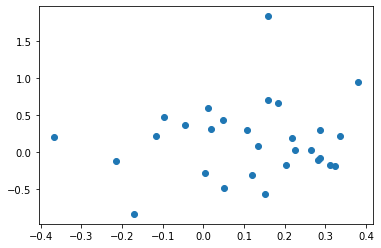

In [238]:
plt.scatter(df_merged.pct_change_adj_close, df_merged.pct_change_fund_size_amt)

In [221]:
df_merged['pct_change_adj_close'].corr(df_merged['avg_fund_size_amt'])

0.07250687220510116

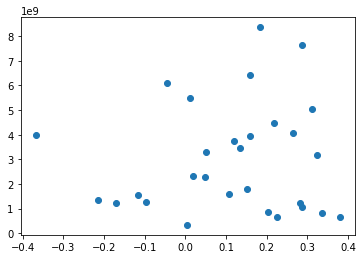

In [239]:
plt.scatter(df_merged.pct_change_adj_close, df_merged.avg_fund_size_amt)

In [222]:
df_merged['volatility'].corr(df_merged['pct_change_fund_size_amt'])

-0.09295513542178833

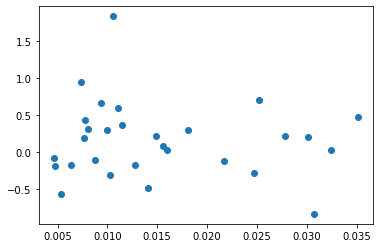

In [240]:
plt.scatter(df_merged.volatility, df_merged.pct_change_fund_size_amt)

In [223]:
df_merged['volatility'].corr(df_merged['avg_fund_size_amt'])

-0.3861680234575997

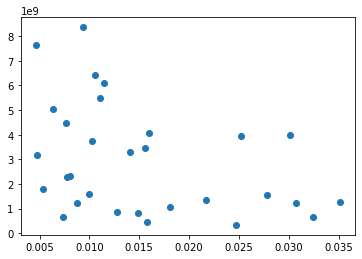

In [241]:
plt.scatter(df_merged.volatility, df_merged.avg_fund_size_amt)

In [224]:
df_merged.avg_fund_size_amt.nsmallest(5)

1    3.385642e+08
0    4.719266e+08
2    6.591820e+08
3    6.750360e+08
4    8.160065e+08
Name: avg_fund_size_amt, dtype: float64

In [225]:
## percent changes for emerging funds in particular

df_emerging = df_merged[df_merged['avg_fund_size_amt'] <= 250000000]
df_emerging.head()

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_size_amt,avg_commit_amt,pct_change_commit_amt


No average fund size less than or equal to $250M in LP Commitments data

In [226]:
## retrying with year by year funds data

df_funds = pd.read_csv('buyouts_funds/buyouts_funds_csv/buyouts_funds_final.csv')
df_funds = df_funds.sort_values('vintage_year', ascending=False)
df_funds = df_funds[df_funds['vintage_year'] != 0]
df_funds.head()

,fund_id,fund_name,fm_id,strategy,sector,region,country,target_fund_size_amt,target_fund_size_currency,fund_size_amt,fund_currency,status,stage,vintage_year,open_date
6950,62131,Corridor Capital Title II,12869,Buyout / Corporate Private Equity,TMT,North America,NaN,NaN,NaN,13260000.0,USD,Launched,NaN,2022,2022-4
6177,61228,Altera Vision PA,22927,Venture Capital / Growth Equity,Diversified,North America,NaN,5250000.0,USD,3560000.0,USD,Currently Investing,1st Close,2022,2022-2
6193,61238,Third Lake PC NCBDC Fund,20727,Mezzanine / Debt,Diversified,North America,NaN,NaN,NaN,NaN,NaN,Launched,NaN,2022,2022-2
6192,61237,Barings CMS Fund,2161,Mezzanine / Debt,Diversified,North America,NaN,NaN,NaN,NaN,NaN,Launched,NaN,2022,2022-0
6189,61232,Perennial Private Growth Ventures Fund,22930,Venture Capital / Growth Equity,Diversified,Middle East/Africa,NaN,200000000.0,USD,NaN,NaN,Launched,NaN,2022,2022-3


In [227]:
df_funds = df_funds[['vintage_year', 'fund_size_amt', 'target_fund_size_amt']]
df_funds.head()

,vintage_year,fund_size_amt,target_fund_size_amt
6950,2022,13260000.0,NaN
6177,2022,3560000.0,5250000.0
6193,2022,NaN,NaN
6192,2022,NaN,NaN
6189,2022,NaN,200000000.0


In [228]:
df_funds_grouped = df_funds.groupby('vintage_year', as_index=False).agg({'fund_size_amt':'mean',
                                                                        'target_fund_size_amt':'mean'})
df_funds_grouped = df_funds_grouped.sort_values('vintage_year', ascending=False)
df_funds_grouped = df_funds_grouped.rename(columns={'vintage_year':'year', 'fund_size_amt':'avg_fund_size_amt',
                                                   'target_fund_size_amt':'avg_target_fund_size_amt'})
df_funds_grouped.head()

,year,avg_fund_size_amt,avg_target_fund_size_amt
3,2022,3.468283e+08,3.293141e+09
2,2021,8.073735e+08,1.833711e+09
1,2020,4.589803e+08,1.141979e+09
0,2019,1.436815e+09,3.027148e+08


In [229]:
## merge S&P data with funds data

df_merged2 = pd.merge(df_agg, df_funds_grouped, on='year')
df_merged2 = df_merged2.sort_values('year')
df_merged2.head()

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,avg_target_fund_size_amt
0,2019,322.130005,320.149994,310.837585,0.312239,0.006370,1.436815e+09,3.027148e+08
1,2020,374.660004,371.230011,367.819122,0.183316,0.009325,4.589803e+08,1.141979e+09
2,2021,476.859985,474.670013,473.489044,0.287288,0.004625,8.073735e+08,1.833711e+09
3,2022,404.040009,391.959991,392.750000,-0.170519,0.030758,3.468283e+08,3.293141e+09


In [230]:
## look at percent changes in allocation of funds

df_merged2['pct_change_fund_amt'] = df_merged2['avg_fund_size_amt'].pct_change()
df_merged2['pct_change_target_amt'] = df_merged2['avg_target_fund_size_amt'].pct_change()

df_merged2 = df_merged2[['year', 'high', 'low', 'adj_close', 'pct_change_adj_close',
                      'volatility', 'avg_fund_size_amt', 'pct_change_fund_amt',
                      'avg_target_fund_size_amt', 'pct_change_target_amt']]

df_merged2.head()

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt,avg_target_fund_size_amt,pct_change_target_amt
0,2019,322.130005,320.149994,310.837585,0.312239,0.006370,1.436815e+09,NaN,3.027148e+08,NaN
1,2020,374.660004,371.230011,367.819122,0.183316,0.009325,4.589803e+08,-0.680557,1.141979e+09,2.772458
2,2021,476.859985,474.670013,473.489044,0.287288,0.004625,8.073735e+08,0.759059,1.833711e+09,0.605731
3,2022,404.040009,391.959991,392.750000,-0.170519,0.030758,3.468283e+08,-0.570424,3.293141e+09,0.795889


In [232]:
## percent changes for emerging funds in particular

df_emerging2 = df_merged2[df_merged2['avg_fund_size_amt'] <= 250000000]
df_emerging2.head()

,year,high,low,adj_close,pct_change_adj_close,volatility,avg_fund_size_amt,pct_change_fund_amt,avg_target_fund_size_amt,pct_change_target_amt


No average fund size less than or equal to $250M in Funds data

In [233]:
## correlations

df_merged2['pct_change_adj_close'].corr(df_merged2['pct_change_fund_amt'])

0.6234590837464378

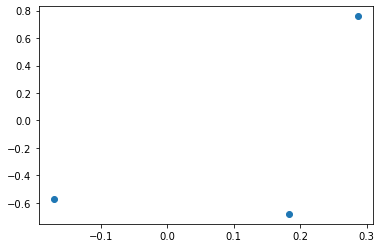

In [242]:
plt.scatter(df_merged2.pct_change_adj_close, df_merged2.pct_change_fund_amt)

In [234]:
df_merged2['pct_change_adj_close'].corr(df_merged2['avg_fund_size_amt'])

0.7279554094232358

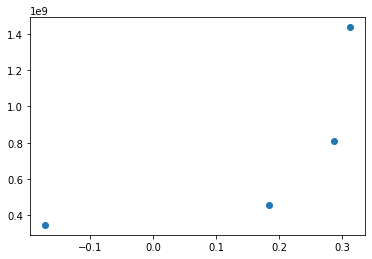

In [243]:
plt.scatter(df_merged2.pct_change_adj_close, df_merged2.avg_fund_size_amt)

In [235]:
df_merged2['volatility'].corr(df_merged2['pct_change_fund_amt'])

-0.5845520724135566

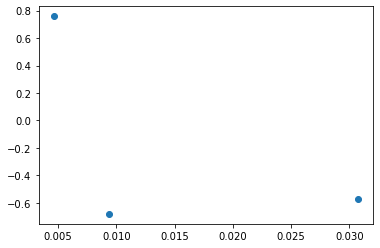

In [244]:
plt.scatter(df_merged2.volatility, df_merged2.pct_change_fund_amt)

In [236]:
df_merged2['volatility'].corr(df_merged2['avg_fund_size_amt'])

-0.6217189931930354

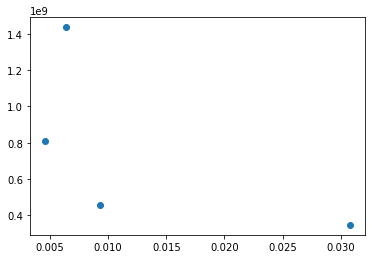

In [245]:
plt.scatter(df_merged2.volatility, df_merged2.avg_fund_size_amt)

In [237]:
df_merged2.avg_fund_size_amt.nsmallest(5)

3    3.468283e+08
1    4.589803e+08
2    8.073735e+08
0    1.436815e+09
Name: avg_fund_size_amt, dtype: float64

### buyouts: funds

In [74]:
df_funds = pd.read_csv('buyouts_funds/buyouts_funds_csv/buyouts_funds_final.csv')
df_funds.head()

,fund_id,fund_name,fm_id,strategy,sector,region,country,target_fund_size_amt,target_fund_size_currency,fund_size_amt,fund_currency,status,stage,vintage_year,open_date
0,34866,Ascent Venture Partners VII,6381,Venture Capital / Growth Equity,TMT,North America,United States,150000000.0,USD,NaN,NaN,Launched,NaN,2020,2020-0
1,36284,Fall Line Endurance Fund (Open-Ended),15168,Venture Capital / Growth Equity,TMT,North America,United States,NaN,NaN,285000000.0,USD,Currently Investing,NaN,2019,2016-7
2,36284,Fall Line Endurance Fund (Open-Ended),15168,Venture Capital / Growth Equity,Agribusiness,North America,United States,NaN,NaN,285000000.0,USD,Currently Investing,NaN,2019,2016-7
3,39769,Star Mountain U.S. LMM Secondary Fund II,1671,Secondaries,Diversified,North America,United States,500000000.0,USD,200000000.0,USD,Currently Investing,1st Close,2020,2020-12
4,43372,Waterfall Sentinel Fund I,19136,Buyout / Corporate Private Equity,Diversified,North America,United States,300000000.0,USD,80000000.0,USD,Currently Investing,1st Close,2019,2019-1


In [77]:
df_funds = df_funds.sort_values('vintage_year', ascending=False)
df_funds.head()

,fund_id,fund_name,fm_id,strategy,sector,region,country,target_fund_size_amt,target_fund_size_currency,fund_size_amt,fund_currency,status,stage,vintage_year,open_date
6950,62131,Corridor Capital Title II,12869,Buyout / Corporate Private Equity,TMT,North America,NaN,NaN,NaN,13260000.0,USD,Launched,NaN,2022,2022-4
6165,61214,KKR Lending Partners IV,5586,Mezzanine / Debt,Diversified,Western Europe,NaN,NaN,NaN,NaN,NaN,Launched,NaN,2022,2022-3
6166,61214,KKR Lending Partners IV,5586,Mezzanine / Debt,Diversified,North America,NaN,NaN,NaN,NaN,NaN,Launched,NaN,2022,2022-3
6039,61064,TPG Partners IX,6701,Buyout / Corporate Private Equity,Diversified,Middle East/Africa,United Kingdom,1.850000e+10,USD,NaN,NaN,Launched,NaN,2022,2022-1
6186,61232,Perennial Private Growth Ventures Fund,22930,Venture Capital / Growth Equity,Diversified,Asia-Pacific,NaN,2.000000e+08,USD,NaN,NaN,Launched,NaN,2022,2022-3


In [88]:
df_funds.tail()

,fund_id,fund_name,fm_id,strategy,sector,region,country,target_fund_size_amt,target_fund_size_currency,fund_size_amt,fund_currency,status,stage,vintage_year,open_date
571,49138,OC4 Ventures Fund I,20354,Venture Capital / Growth Equity,TMT,North America,United States,10000000.0,USD,250000.0,USD,Currently Investing,1st Close,2019,2019-11
570,49113,Spire Capital Partners IV,7103,Buyout / Corporate Private Equity,TMT,North America,NaN,NaN,NaN,291550000.0,USD,Currently Investing,2nd Close,2019,2019-11
569,49113,Spire Capital Partners IV,7103,Buyout / Corporate Private Equity,Business Services,North America,NaN,NaN,NaN,291550000.0,USD,Currently Investing,2nd Close,2019,2019-11
568,49075,Elephant Partners III,16906,Venture Capital / Growth Equity,TMT,North America,United States,350000000.0,USD,NaN,NaN,Currently Investing,1st Close,2019,2019-11
3475,56899,Renegade Partners I,22225,Venture Capital / Growth Equity,TMT,North America,NaN,300000000.0,USD,100000000.0,USD,Currently Investing,1st Close,2019,2020-3


### buyouts: LP commitments

In [288]:
df_lp = pd.read_csv('buyouts_lp/buyouts_lp_csv/lp_commitments.csv')
df_lp.head()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
0,215027,3,60421,Greenspring Global Partners V,7045,StepStone Group,Healthcare,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Asia-Pacific,2011
1,195565,3,60421,Greenspring Global Partners V,7045,StepStone Group,TMT,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Asia-Pacific,2011
2,181373,3,60421,Greenspring Global Partners V,7045,StepStone Group,Healthcare,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Latin America,2011
3,125752,3,60421,Greenspring Global Partners V,7045,StepStone Group,TMT,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Latin America,2011
4,88550,3,60421,Greenspring Global Partners V,7045,StepStone Group,Healthcare,Fund of Funds / Co-Investment,356190000.0,USD,NaN,NaN,Western Europe,2011


In [289]:
df_lp = df_lp.sort_values('vintage_year', ascending=False)
df_lp.head()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
243986,162760,22750,60617,Genesia Venture Fund III,19397,Genesia Ventures,TMT,Venture Capital / Growth Equity,1.000000e+10,JPY,NaN,NaN,Asia-Pacific,2022
41802,230179,302,60838,Apax XI,6373,Apax Partners,TMT,Buyout / Corporate Private Equity,0.000000e+00,USD,100000000.0,USD,Middle East/Africa,2022
41818,984,302,60920,Blackstone Growth II,5611,Blackstone,TMT,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41817,90581,302,60920,Blackstone Growth II,5611,Blackstone,Healthcare,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41816,151888,302,60920,Blackstone Growth II,5611,Blackstone,Consumer Goods,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022


In [290]:
df_lp = df_lp[df_lp['vintage_year'] != 0]
df_lp.head()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
243986,162760,22750,60617,Genesia Venture Fund III,19397,Genesia Ventures,TMT,Venture Capital / Growth Equity,1.000000e+10,JPY,NaN,NaN,Asia-Pacific,2022
41802,230179,302,60838,Apax XI,6373,Apax Partners,TMT,Buyout / Corporate Private Equity,0.000000e+00,USD,100000000.0,USD,Middle East/Africa,2022
41818,984,302,60920,Blackstone Growth II,5611,Blackstone,TMT,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41817,90581,302,60920,Blackstone Growth II,5611,Blackstone,Healthcare,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022
41816,151888,302,60920,Blackstone Growth II,5611,Blackstone,Consumer Goods,Venture Capital / Growth Equity,0.000000e+00,USD,150000000.0,USD,North America,2022


In [291]:
df_lp.tail()

,lp_commitment_id,lp_id,fund_id,fund_name,fund_manager_id,fund_manager,sectors,strategies,fund_size_amt,fund_size_currency,commitment_amt,commitment_currency,regions,vintage_year
42682,103572,314,15212,New Enterprise Associates I,6610,New Enterprise Associates,Healthcare,Venture Capital / Growth Equity,16000000.0,USD,72000.0,USD,North America,1978
42683,11756,314,15212,New Enterprise Associates I,6610,New Enterprise Associates,TMT,Venture Capital / Growth Equity,16000000.0,USD,72000.0,USD,North America,1978
84678,169189,542,15212,New Enterprise Associates I,6610,New Enterprise Associates,Healthcare,Venture Capital / Growth Equity,16000000.0,USD,50000000.0,USD,North America,1978
217369,131578,14598,25103,Charles River II,6429,CRV,Diversified,Venture Capital / Growth Equity,6800000.0,USD,NaN,NaN,North America,1976
224583,221613,15532,25103,Charles River II,6429,CRV,Diversified,Venture Capital / Growth Equity,6800000.0,USD,NaN,NaN,North America,1976


In [292]:
#df_lp['avg_fund_size_amt'] = df_lp.groupby("vintage_year")['fund_size_amt'].transform('mean')
#df_lp.head()

In [293]:
df_lp_grouped = df_lp.groupby('vintage_year',as_index=False).agg({'fund_size_amt':'mean', 'commitment_amt':'mean'})
df_lp_grouped

,vintage_year,fund_size_amt,commitment_amt
0,1976,6.800000e+06,NaN
1,1978,1.600000e+07,1.835733e+07
2,1979,3.135000e+07,2.000000e+06
3,1980,7.699545e+07,4.332000e+07
4,1981,3.552000e+07,3.865455e+07
5,1982,3.815125e+08,7.548600e+06
6,1983,1.448451e+08,1.641667e+07
7,1984,1.040575e+08,1.113846e+07
8,1985,1.138329e+08,1.055661e+07
9,1986,5.510820e+08,7.628571e+06


In [294]:
df_lp_grouped = df_lp_grouped.sort_values('vintage_year', ascending=False)
df_lp_grouped

,vintage_year,fund_size_amt,commitment_amt
45,2022,1.228527e+09,8.287198e+07
44,2021,7.623665e+09,1.242416e+08
43,2020,8.361854e+09,4.629961e+08
42,2019,5.044311e+09,8.095592e+08
41,2018,6.090554e+09,8.848151e+08
40,2017,4.472146e+09,1.530681e+09
39,2016,3.757126e+09,2.885293e+09
38,2015,5.490946e+09,2.654402e+09
37,2014,3.444918e+09,3.099146e+09
36,2013,3.186252e+09,1.828307e+09


In [296]:
df_lp_grouped = df_lp_grouped.rename(columns={'fund_size_amt':'avg_fund_size_amt', 
                                              'commitment_amt':'avg_commitment_amt'})
df_lp_grouped

,vintage_year,avg_fund_size_amt,avg_commitment_amt
45,2022,1.228527e+09,8.287198e+07
44,2021,7.623665e+09,1.242416e+08
43,2020,8.361854e+09,4.629961e+08
42,2019,5.044311e+09,8.095592e+08
41,2018,6.090554e+09,8.848151e+08
40,2017,4.472146e+09,1.530681e+09
39,2016,3.757126e+09,2.885293e+09
38,2015,5.490946e+09,2.654402e+09
37,2014,3.444918e+09,3.099146e+09
36,2013,3.186252e+09,1.828307e+09


In [254]:
#df_lp['avg_fund_size_amt'] = df_lp.groupby('vintage_year').agg({'fund_size_amt':'mean', 
                                                               #'commitment_amt':'mean'})


In [264]:
#df_lp_final = df_lp_grouped.drop_duplicates(subset=['vintage_year', 'avg_fund_size_amt'])
#df_lp_final

### S&P + LP commitments

In [298]:
df_lp_merge = df_lp_grouped.rename(columns={'vintage_year':'year'})
df_sp_merge = df_sp_final.rename(columns={'converted_years':'year', 'avg_open_yr':'avg_open',
                                         'avg_high_yr':'avg_high', 'avg_low_yr':'avg_low'})
df_merged = pd.merge(df_sp_merge, df_lp_merge, on='year')
df_merged = df_merged.sort_values('year')
df_merged

,year,avg_open,avg_high,avg_low,avg_fund_size_amt,avg_commitment_amt
44,1978,96.117778,96.801190,95.438214,1.600000e+07,1.835733e+07
43,1979,102.980833,103.474048,102.436111,3.135000e+07,2.000000e+06
42,1980,118.713913,119.416403,117.958182,7.699545e+07,4.332000e+07
41,1981,128.038142,129.355968,126.784427,3.552000e+07,3.865455e+07
40,1982,119.705494,121.041107,118.405652,3.815125e+08,7.548600e+06
39,1983,160.473043,161.929091,158.898933,1.448451e+08,1.641667e+07
38,1984,160.463636,161.312885,159.679289,1.040575e+08,1.113846e+07
37,1985,186.828175,187.415754,186.064524,1.138329e+08,1.055661e+07
36,1986,236.391858,237.463913,234.950356,5.510820e+08,7.628571e+06
35,1987,286.995889,289.283439,284.524190,7.904181e+08,2.796233e+07


In [307]:
df_merged['avg_high'].corr(df_merged['avg_fund_size_amt'])

0.7632889955588487

In [308]:
df_merged['avg_low'].corr(df_merged['avg_fund_size_amt'])

0.7649360242313832

In [309]:
df_merged['avg_high'].corr(df_merged['avg_commitment_amt'])

0.39660694898994586

In [310]:
df_merged['avg_low'].corr(df_merged['avg_commitment_amt'])

0.39935689323545853

In [312]:
X = df_merged[['year', 'avg_open', 'avg_high', 'avg_low', 'avg_commitment_amt']]
y = df_merged.avg_fund_size_amt

In [313]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)

In [314]:
pipe = make_pipeline(Lasso(alpha=100, max_iter=1000))

In [315]:
lasso = pipe.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.320289729290673e+19, tolerance: 1.95323112580764e+16
  model = cd_fast.enet_coordinate_descent(


In [316]:
print("Test set score: {:.2f}".format(lasso.score(X_test, y_test)))
print("Number of features used:", np.sum(lasso['lasso'].coef_ != 0))

Test set score: 0.80
Number of features used: 5


In [329]:
X2 = df_merged[['year', 'avg_open', 'avg_high', 'avg_commitment_amt']]

In [330]:
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y, test_size=0.1, random_state=0)

In [331]:
lasso2 = pipe.fit(X_train2, y_train2)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.3510501794343813e+19, tolerance: 1.95323112580764e+16
  model = cd_fast.enet_coordinate_descent(


In [332]:
print("Test set score: {:.2f}".format(lasso2.score(X_test2, y_test2)))
print("Number of features used:", np.sum(lasso2['lasso'].coef_ != 0))

Test set score: 0.81
Number of features used: 4


In [328]:
X3 = df_merged[['avg_open', 'avg_high', 'avg_commitment_amt']]

In [333]:
X_train3, X_test3, y_train3, y_test3 = train_test_split(X3, y, test_size=0.1, random_state=0)

In [334]:
lasso3 = pipe.fit(X_train3, y_train3)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.916409427215324e+19, tolerance: 1.95323112580764e+16
  model = cd_fast.enet_coordinate_descent(


In [335]:
print("Test set score: {:.2f}".format(lasso3.score(X_test3, y_test3)))
print("Number of features used:", np.sum(lasso3['lasso'].coef_ != 0))

Test set score: 0.72
Number of features used: 3


In [317]:
param_grid={'lasso__alpha': np.logspace(1,7,num=13),
           'lasso__max_iter': [10000]}

In [318]:
grid = GridSearchCV(pipe, param_grid=param_grid, cv=10, n_jobs=-1)

In [319]:
grid.fit(X_train, y_train)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.035362651104777e+19, tolerance: 1.8894652170089156e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2.8195043507480035e+19, tolerance: 1.5590305779438276e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:530: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 3.0047171635723977e+19, tolerance: 1.8337897908333212e+16
  model = cd_fast.enet_coordinate_descent(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_desc

GridSearchCV(cv=10, estimator=Pipeline(steps=[('lasso', Lasso(alpha=100))]),
             n_jobs=-1,
             param_grid={'lasso__alpha': array([1.00000000e+01, 3.16227766e+01, 1.00000000e+02, 3.16227766e+02,
       1.00000000e+03, 3.16227766e+03, 1.00000000e+04, 3.16227766e+04,
       1.00000000e+05, 3.16227766e+05, 1.00000000e+06, 3.16227766e+06,
       1.00000000e+07]),
                         'lasso__max_iter': [10000]})

In [320]:
print("Score for the best model: {:.2f}".format(grid.score(X_test, y_test)))

Score for the best model: 0.75


In [321]:
grid.best_params_

{'lasso__alpha': 10000000.0, 'lasso__max_iter': 10000}

In [322]:
grid.best_estimator_

Pipeline(steps=[('lasso', Lasso(alpha=10000000.0, max_iter=10000))])